In [1]:
cd ..

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.poisson_mixture import PoissonMixture
from RADOM.gamma_poisson_mixture import GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

2023.04.12.10


In [3]:
from scipy.stats import spearmanr
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm

# Load data

In [4]:
their_adata = sc.read('data/velocity_anndata_mouse_embryonic_stem_cells_DeepCycle_ISMARA.h5ad')
their_adata.var_names_make_unique
their_adata

AnnData object with n_obs × n_vars = 5637 × 12238
    obs: 'Clusters', '_X', '_Y', 'n_genes', 'percent_mito', 'n_counts', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'louvain', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'cell_cycle_theta'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'gene_count_corr', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'ISMARA_activities', 'dendrogram_louvain', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'recover_dynamics', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spliced', 'uns

In [5]:
alldata = sc.read('/home/mffang/data/counts/DeepCycle/SRR13790993/counts_filtered/adata.loom')
alldata

AnnData object with n_obs × n_vars = 6391 × 55471
    obs: 'barcode'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

In [6]:
their_barcodes = [ bc[7:-1] for bc in their_adata.obs_names ]
cell_idx = [np.where(alldata.obs['barcode']==bc)[0][0] for bc in their_barcodes]
adata = alldata[cell_idx]
adata

View of AnnData object with n_obs × n_vars = 5637 × 55471
    obs: 'barcode'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

Text(0.5, 0, 'theirs')

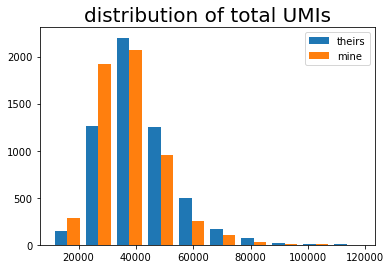

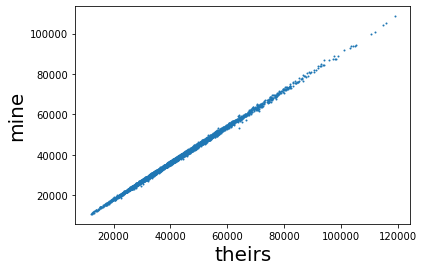

In [7]:
adata_total_UMI =  adata.layers['unspliced'].toarray().sum(1) + adata.layers['spliced'].toarray().sum(1)

plt.hist([their_adata.layers['matrix'].toarray().sum(1),adata_total_UMI],label=['theirs','mine'])
plt.legend()
plt.title('distribution of total UMIs',fontsize=20)

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(their_adata.layers['matrix'].toarray().sum(1),adata_total_UMI,s=1)
plt.ylabel("mine",fontsize=20)
plt.xlabel("theirs",fontsize=20)

In [8]:
adata.var_names = adata.var['gene_name']

In [44]:
clusters = np.around(their_adata.obs['cell_cycle_theta'],1)
Clusters = set(clusters)
Clusters

{0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0}

In [45]:
color_palette = ["#84b753","#c3d585","#d3e4e2","#77a6ac","#405759"]
from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Clusters))

cell_colors = cmap_cluster(clusters)

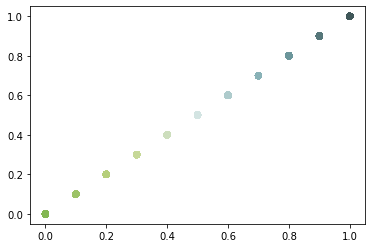

In [89]:
plt.scatter(clusters,clusters,c=cell_colors)

In [80]:
x = their_adata.obsm['X_pca']

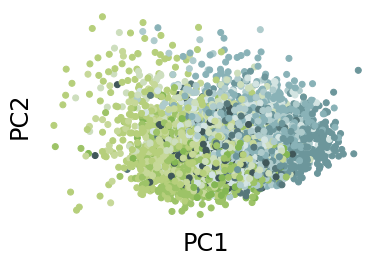

In [81]:
fig, ax = plt.subplots(1,1)
ax.scatter(x[:,0],x[:,1],c=cell_colors);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [56]:
known_marker_genes=["Geminin", "Cdt1", 'Mcm6', 'Mcmc2','Cdk1','Top2a','Kif11',"Plk1","RFC1"]
marker_genes=["Geminin", "Cdt1", 'Mcm6', 'Mcmc2','Cdk1','Top2a','Kif11',"Plk1","RFC1"]

# Select genes

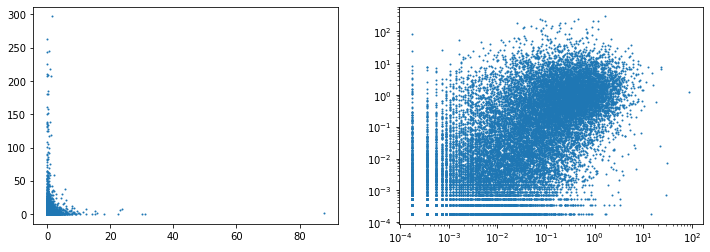

In [48]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [49]:
idx = (adata.layers["unspliced"].toarray().mean(0) > 0) 
U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))


idx = adata.layers["spliced"].toarray().mean(0) > 0
S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X = U + S
X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.14108230877556238
s estimated by normalized covariance of total S counts = 0.11855534459650742
s estimated by normalized covariance of total counts = 0.1151548054755232
s estimated by total counts = 0.09990595072769508


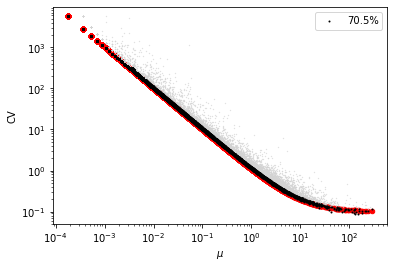

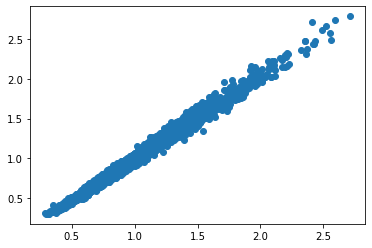

In [50]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()

X_bar = np.mean(U + S, axis=0)
X_var = np.var(U + S, axis=0)
a=1
s=s2
Pgene_mask = (X_bar > 0) & (X_var/(a*X_bar + s*X_bar**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

plt.figure()
plt.scatter(rd,adata.X.toarray().mean(1)/adata.X.toarray().mean())

In [54]:
cell_cycle_genes = pd.read_csv('data/cell_cycle_genes.txt',header=None)
cell_cycle_genes = np.array(cell_cycle_genes[0],dtype=str)
ccg_idx = adata.var["gene_name"].isin(cell_cycle_genes)
ccg_idx.sum()

1278

(5637, 2608, 2)

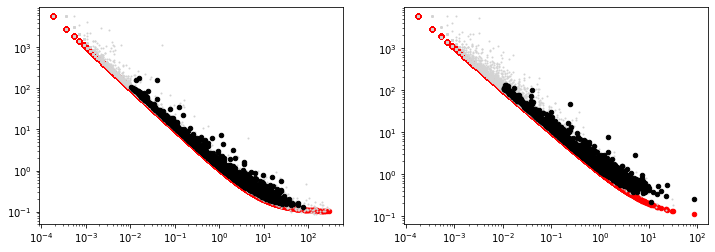

In [60]:
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.01) & (S_mean > 0.01) \
    & (np.abs(np.log10(S_mean/U_mean)) < 2) \
    & (U_var/(a*U_mean + s2*U_mean**2) > 1.1) \
    & (S_var/(a*S_mean + s2*S_mean**2) > 1.1)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + s2, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + s2, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [69]:
overlap_idx = (fitted_idx & ccg_idx)

X=np.zeros((n,overlap_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,overlap_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,overlap_idx].toarray()
fitted_genes=adata.var_names[overlap_idx]
X.shape

(5637, 356, 2)

In [70]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index(['Mcm6', 'Cdk1', 'Top2a', 'Kif11', 'Plk1'], dtype='object', name='gene_name')


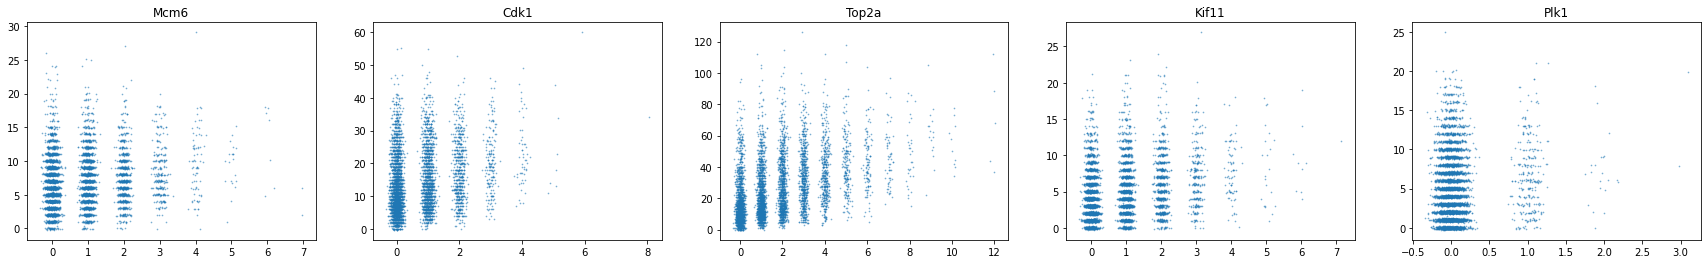

In [71]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

# Mixtures fitting

In [72]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

In [73]:
GPMs = []
for nc in range(2,6):
    GPM = GammaPoissonMixture(n_components=nc,verbose=0)
    Q, elbo = GPM.fit(X_mix,warm_start=False,epoch=5,n_init=3)
    GPMs.append(GPM)
    print(nc,GPM.compute_AIC(X_mix))

2 -1008.4650220893625
3 -1001.0335034602291
4 -994.8353261976104
5 -996.5349792072022


In [74]:
for GPM in GPMs:
    print(GPM.compute_BIC(X_mix))

-1009.3051100883063
-1002.2939298132345
-996.5160909046773
-998.6360822683308


In [84]:
GPM = GammaPoissonMixture(n_components=3,verbose=1)
Q, elbo = GPM.fit(X_mix,warm_start=False,epoch=10,n_init=5)
GPM.weights, 1/GPM.alpha

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


(array([0.07924664, 0.43013818, 0.49061518]),
 array([0.20242522, 0.097321  , 0.09572432]))

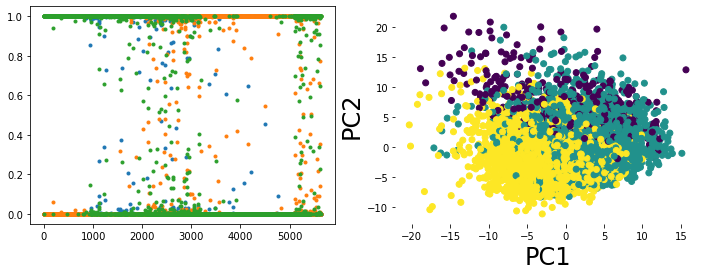

In [85]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=np.argmax(Q,axis=1));
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

Text(0.5, 1.0, 'intercept test p value')

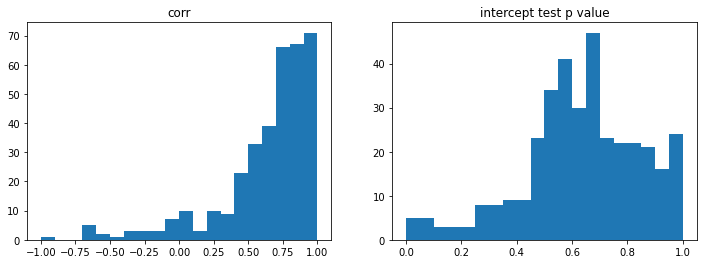

In [86]:
slope, intercept, corr, pval = linear_regression(GPM.theta)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(corr,bins=np.linspace(-1,1,21))
ax[0].set_title('corr')
ax[1].hist(pval,bins=np.linspace(0,1,21))
ax[1].set_title('intercept test p value')

In [77]:
GPM = GammaPoissonMixture(n_components=4,verbose=0)
Q, elbo = GPM.fit(X_mix,warm_start=False,epoch=10,n_init=5)
GPM.weights, 1/GPM.alpha

(array([0.46722281, 0.13201287, 0.33865677, 0.06210755]),
 array([0.09418301, 0.11815123, 0.09561675, 0.18598918]))

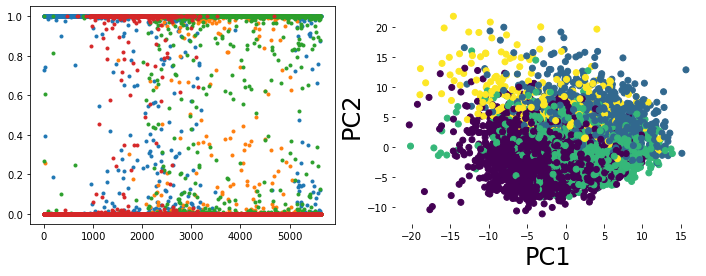

In [83]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=np.argmax(Q,axis=1));
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

Text(0.5, 1.0, 'intercept test p value')

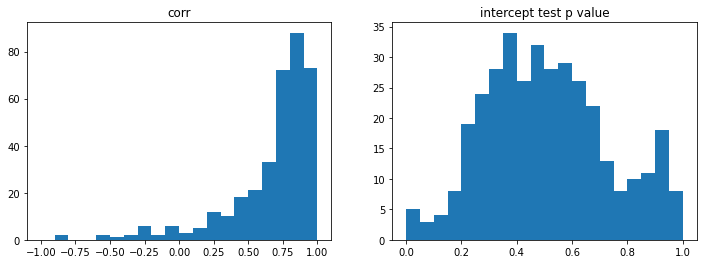

In [79]:
slope, intercept, corr, pval = linear_regression(GPM.theta)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(corr,bins=np.linspace(-1,1,21))
ax[0].set_title('corr')
ax[1].hist(pval,bins=np.linspace(0,1,21))
ax[1].set_title('intercept test p value')

# Trajectory fitting

In [87]:
elbos = {}
params={'r':rd,"lambda_tau":0,"lambda_a":0}

## Fine cluster

In [88]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

In [200]:
topo = np.array([[0,1,2,3,0]])
tau = (0,1,4,8,10) 
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=10,epoch=10)
print(traj.elbos[-1])

fitting with warm start


100%|██████████| 10/10 [01:32<00:00,  9.25s/it]

-1027.7792848639474


[ 0.          1.43563722  4.14344485  8.11062591 10.        ]


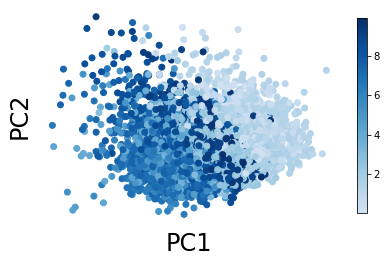

In [201]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

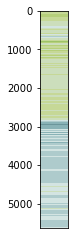

In [202]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

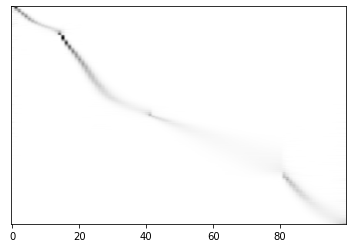

In [203]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

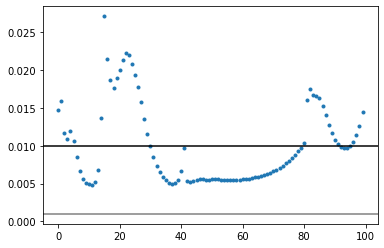

In [204]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

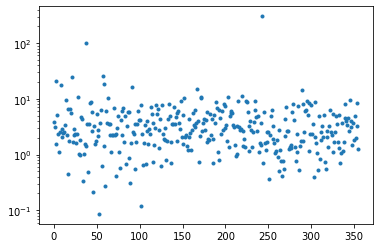

In [205]:
plt.plot(traj.theta[:,[-2]],'.')
plt.yscale('log')

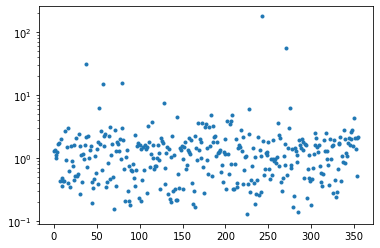

In [206]:
plt.plot(traj.theta[:,[-1]],'.')
plt.yscale('log')

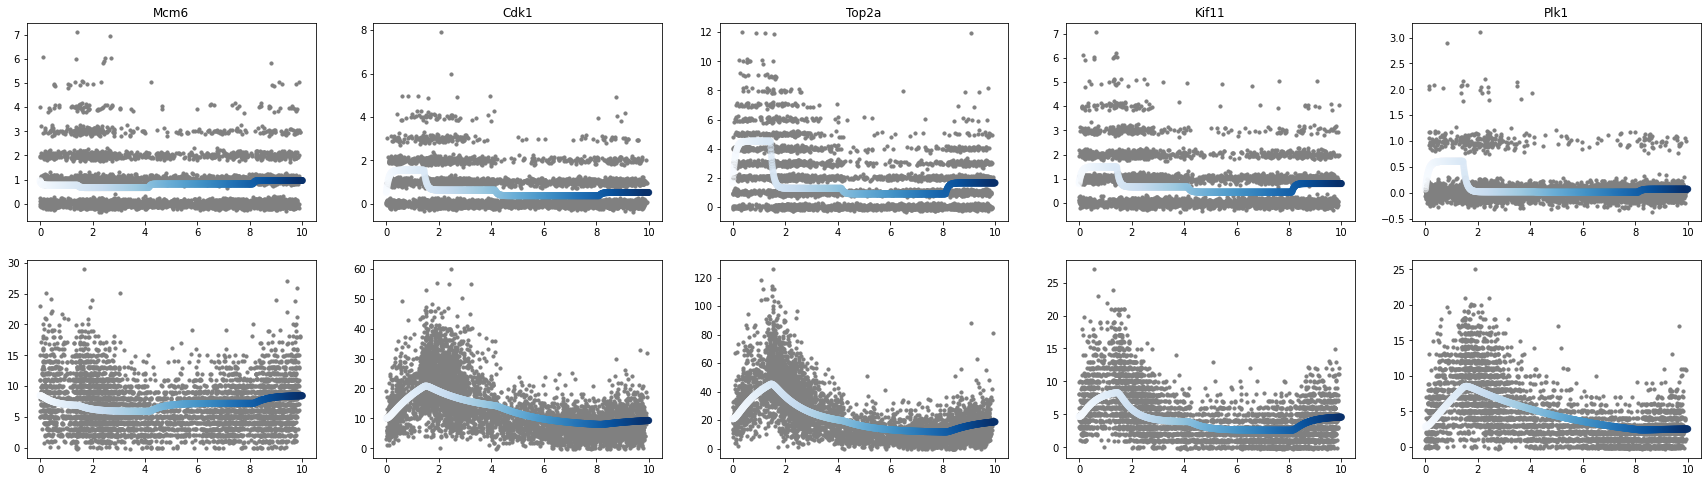

In [207]:
plot_y(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

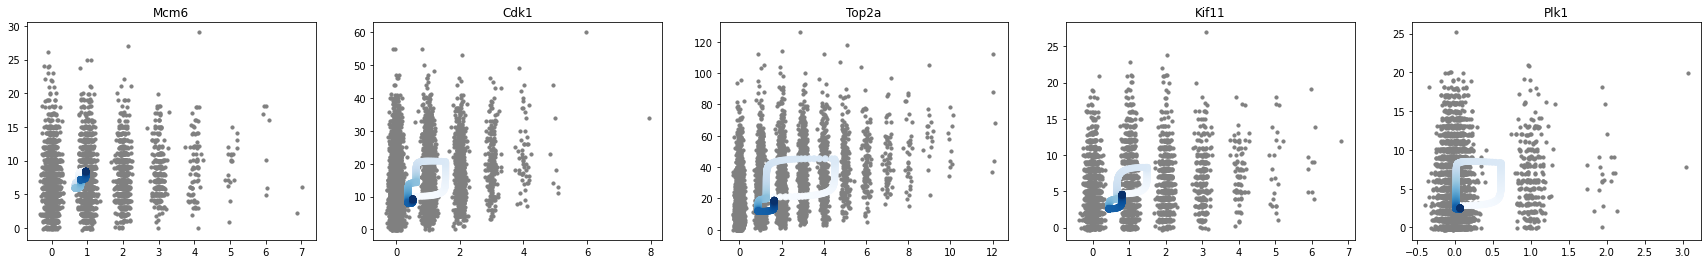

In [208]:
plot_phase(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

In [209]:
plot_marker_genes = ['Cdt1','Mcm2']

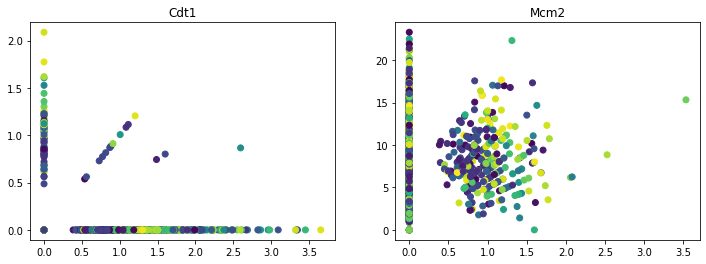

In [210]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

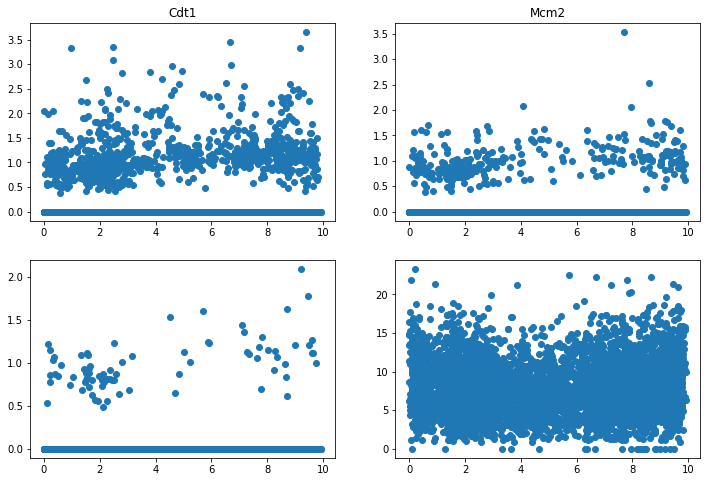

In [211]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

[Text(0, 0, 'α0'), Text(1, 0, 'α1'), Text(2, 0, 'α2')]

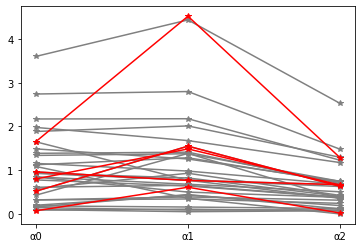

In [212]:
p=30
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='red')

x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
#plt.yscale('log')

In [213]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Fitting without prior

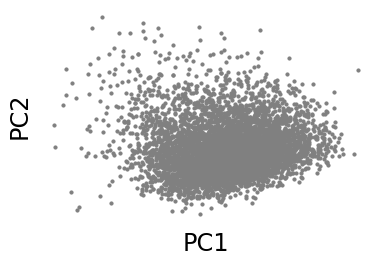

In [214]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [217]:
tau = (0,2,4,8,10)
topo = np.array([[0,1,2,3,0]])
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, fit_tau=True, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

100%|██████████| 100/100 [2:35:17<00:00, 93.17s/it]  


Text(0.5, 1.0, 'Random initialiazation')

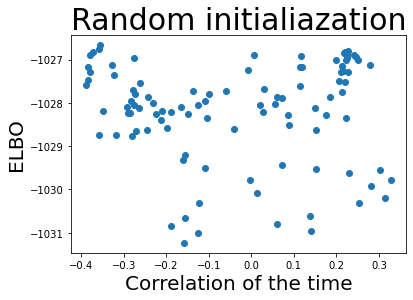

In [218]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

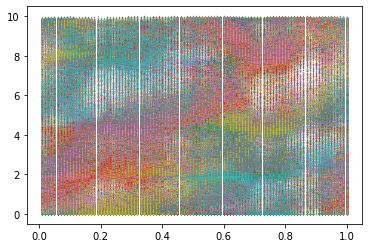

In [226]:
for traj in trajs:
    plt.scatter(their_adata.obs['cell_cycle_theta'],traj.Q[:,0] @ traj.t,s=0.1)

-1026.6676799515235

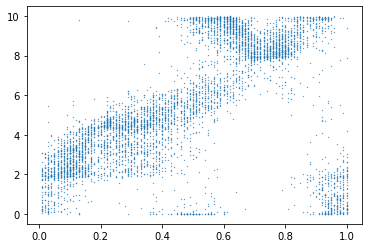

In [227]:
traj = trajs[np.argmax(elbos)]
plt.scatter(their_adata.obs['cell_cycle_theta'],traj.Q[:,0] @ traj.t,s=0.1)
np.max(elbos)

[ 0.          1.9191929   4.50576589  7.97979983 10.        ]


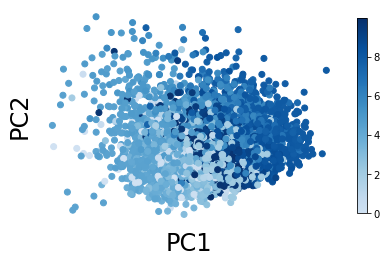

In [220]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

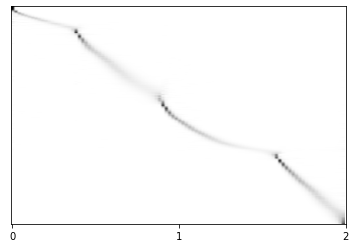

In [221]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

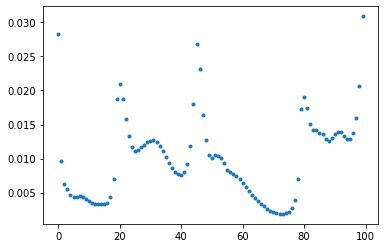

In [222]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.')

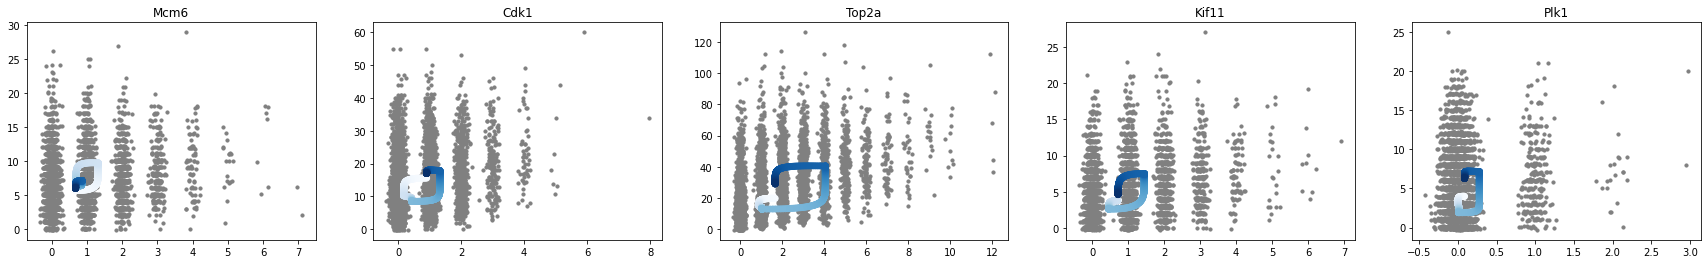

In [223]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

### two_species_ss_tau

In [ ]:
tau = (0,2,4,8,10)
topo = np.array([[0,1,2,3,0]])
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species_ss_tau", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

In [230]:
elbos = []
for traj in trajs:
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )

traj = trajs[np.argmax(elbos)]
plt.scatter(their_adata.obs['cell_cycle_theta'],traj.Q[:,0] @ traj.t,s=0.1)
np.max(elbos)

ValueError: attempt to get argmax of an empty sequence

(array([171.,   4.,  17.,  12.,  18.,  34.,   9.,  23.,   9., 196.]),
 array([23.5, 23.6, 23.7, 23.8, 23.9, 24. , 24.1, 24.2, 24.3, 24.4, 24.5]),
 <BarContainer object of 10 artists>)

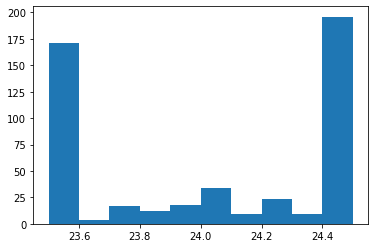

In [236]:
plt.hist(traj.theta[:,-3])

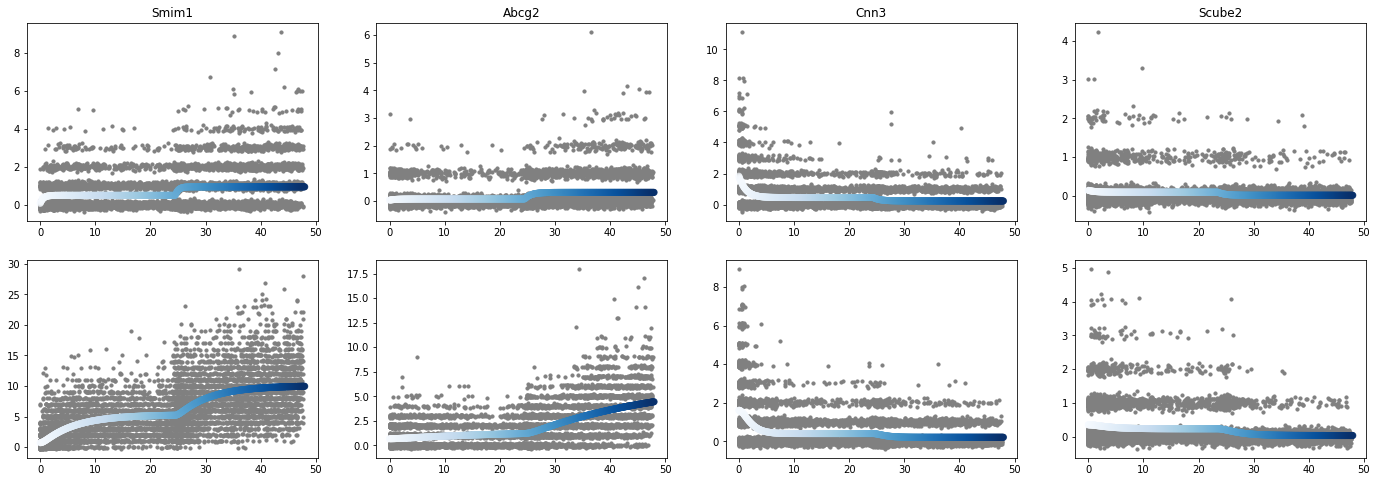

In [237]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

# Synthetic data

In [299]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=4,epoch=10)

fitting with warm start


100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


In [301]:
print(traj.elbos[-1])

-658.4752472018502


[ 0.         23.94425778 48.        ]


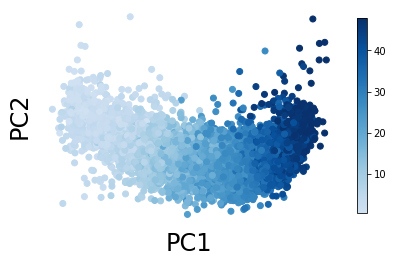

In [300]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

<AxesSubplot:>

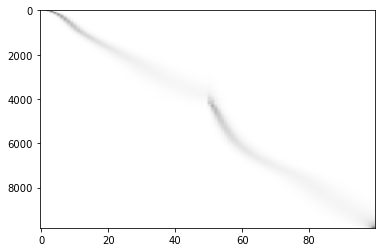

In [302]:
plot_t(traj,order_cells=True)

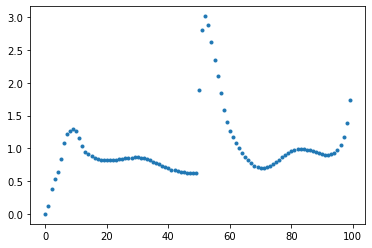

In [303]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum()*traj.m,'.')

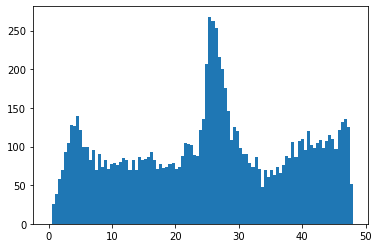

In [304]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(rd[:,None,None]*Y[0])
syn_t = traj.Q[:,0]@traj.t
plt.hist(syn_t,bins=traj.t);

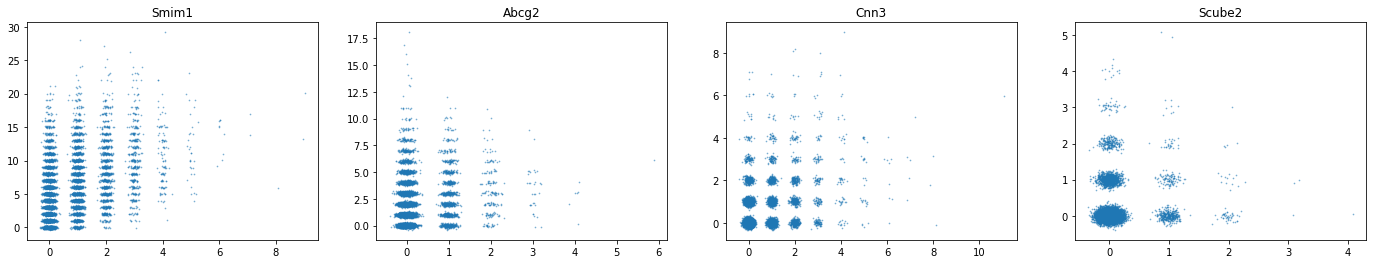

In [307]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [309]:
syn_tau = traj.tau.copy()
syn_topo = traj.topo.copy()
trajs = []
for seed in tqdm(range(20)):
    syn_traj = Trajectory(syn_topo, syn_tau,  model="two_species_ss", restrictions={}, verbose=0)
    syn_traj = syn_traj.fit(syn_X, warm_start=False, fit_tau=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=4, seed=seed)
    trajs.append(syn_traj)

100%|██████████| 20/20 [12:44<00:00, 38.21s/it]


Text(0.5, 1.0, 'Random initialiazation')

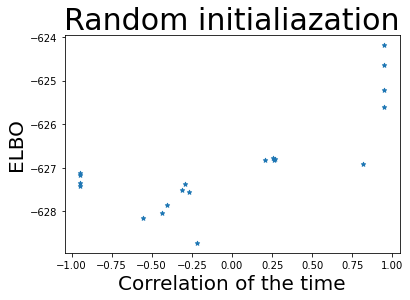

In [310]:
corrs = []
elbos = []
for syn_traj in trajs:
    right_t = syn_t
    t_hat = syn_traj.Q[:,0] @ syn_traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( syn_traj.elbos[np.argmax([syn_traj.elbos[i][-1] for i in range(len(syn_traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)